# Distance to soma  
Plotting quantifications of mitochondrial density and synapse density at different distances to the soma. All quantities we plot are computed over roughly 10 µm segments of basal dendrite.

In [1]:
from meshparty import trimesh_io
import math
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

matplotlib.rc('font', family='sans-serif')
matplotlib.rc('font', serif='Helvetica')

from lib import plot, u, skel, compartment, modelling

Defining some shortcut functions to set a few defaults

In [2]:
def scatterplotdf(df, x, y, xlbl=None, ylbl=None, figsize=(7, 6), **kwargs):
    r, p, fit = plot.scatterplot_df(df, x, y,
                                    xlbl=xlbl, ylbl=ylbl, **kwargs)

    if fit is not None:
        print(fit.params)
    print((r, p, r**2))
    print(len(df))

In [3]:
def plotgradient(df, xname, yname, *args, 
                 color="#aaaaaa", statstype="meanstddev", plottype="margin",
                 xlabel=True, **kwargs):
    plot.plot_distance_gradient_df(df, xname, yname, *args, color=color,
                                   statstype=statstype, plottype=plottype,
                                   **kwargs)
    if not xlabel:
        plt.xlabel("")

# Reading data & setup

In [4]:
analysisids = u.readids("data/pyc_analysis_ids.csv")
completeids = u.readids("data/pyc_analysis_completesoma_ids.csv")

In [5]:
mitodf = pd.read_csv("data/pni_mito_analysisids_fullstats.csv", index_col=0)

In [6]:
mitodf = mitodf[mitodf.cellid.isin(analysisids)]

In [7]:
mitodf.head()

,mito_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,bbox_beg_x_vx,bbox_beg_y_vx,bbox_beg_z_vx,bbox_end_x_vx,bbox_end_y_vx,bbox_end_z_vx,cellid,ctr_pos_x_nm,ctr_pos_y_nm,ctr_pos_z_nm,surface_area,complexityindex,compartment,pathlength
mito_id,,,,,,,,,,,,,,,,,,
2740474,274528,91786,54770,1149,90910,54262,1075,92688,55174,1189,648518346349491311,367144,219080,45960,4.619493,31.516497,Basal,8844.850183
1118099,330204,62682,57352,963,62072,56704,945,63402,58050,981,648518346349491311,250728,229408,38520,4.780969,24.149679,Basal,7005.947856
2496428,82572,86324,49084,1425,86108,48946,1414,86514,49182,1437,648518346349491311,345296,196336,57000,1.159900,5.514730,Basal,1799.573843
1886895,87536,76536,38810,1592,76166,38656,1562,76858,38964,1628,648518346349491311,306144,155240,63680,1.670600,14.661304,Basal,3828.361034
1649845,984232,71966,39020,1221,71236,38656,1063,73346,39484,1347,648518346349491311,287864,156080,48840,12.159270,44.715253,Basal,14378.311217


In [8]:
mitodf.shape

(176072, 18)

In [9]:
Counter(mitodf.compartment)

Counter({'Basal': 53318,
         'Somatic': 90193,
         'Axonal': 11484,
         'Apical': 18608,
         'Unknown': 1811,
         'Unknown dendritic': 658})

In [10]:
dbidf = pd.read_csv("data/distancebinfullstats.csv", index_col=0)
dbidiamdf = pd.read_csv("data/distancebindiameters.csv", index_col=0)
dbidistdf = pd.read_csv("data/distancebinproximity.csv", index_col=0)

In [11]:
dbidf = u.joinbybranchid(dbidf, dbidiamdf, dbidistdf)

In [12]:
dbidf.head()

,cellid,branchid,complbl,pathlength,volume,surfacearea,synapsecount,mitovol,coveredpathlength,uncoveredpathlength,...,surfsynapsedensity,linearsynapsedensity,mindiam,meandiam,mediandiam,maxdiam,mindisttosoma,meandisttosoma,maxdisttosoma,mindisttoleaf
0,648518346349491311,59,2,8.336951,1.369685,19.323307,6,0.047545,1.853665,6.483286,...,0.310506,0.719688,102.471483,289.911608,266.302734,689.260385,90.088670,94.339639,98.425621,0.000000
1,648518346349491311,139,2,9.887459,2.974069,42.935658,15,0.146828,6.141926,3.745532,...,0.349360,1.517073,179.047539,411.631094,383.224273,908.072145,80.050299,85.089340,89.937758,8.487863
2,648518346349491311,169,2,0.415294,0.002504,0.152220,0,0.000000,0.000000,0.415294,...,0.000000,0.000000,0.000000,71.930752,88.414066,110.894876,100.101990,100.287947,100.517284,0.000000
3,648518346349491311,288,2,9.865339,2.126174,30.738989,11,0.053000,2.590718,7.274621,...,0.357852,1.115015,86.768877,358.952583,341.318953,1257.804000,70.060916,74.818864,79.926255,18.499366
4,648518346349491311,291,2,9.851340,4.548748,47.476070,11,0.250772,8.463443,1.387897,...,0.231696,1.116599,96.557593,561.150023,530.064117,1499.293468,90.124799,94.875415,99.976140,0.541145


### Dataframe for distance-gradient plots  
(including the full branch aside from within 5$\mu$m of the leaves)

In [13]:
dbifulldenddf = dbidf[(dbidf.cellid.isin(analysisids)) &
                      (dbidf.complbl == 2) &
                      np.isfinite(dbidf.mindisttosoma) &
                      (dbidf.mindisttoleaf > 5) &
                      # getting rid of two outliers from a reconstruction gap
                      # and a skeletonization quirk
                      (dbidf.volume > 0.5) &
                      np.isfinite(dbidf.linearsynapsedensity)
                     ].copy()

dbifulldenddf["samcs"] = dbifulldenddf["mitovol"] / dbifulldenddf["pathlength"]
dbifulldenddf["camcs"] = dbifulldenddf["mitovol"] / dbifulldenddf["coveredpathlength"]
dbifulldenddf.loc[dbifulldenddf.coveredpathlength == 0, "camcs"] = 0
# converting diameter measurements to um
dbifulldenddf.mindiam /= 1000.
dbifulldenddf.meandiam /= 1000.
dbifulldenddf.mediandiam /= 1000.
dbifulldenddf.maxdiam /= 1000.
dbifulldenddf["cylinderarea"] = math.pi * dbifulldenddf["mediandiam"] * dbifulldenddf["pathlength"]
dbifulldenddf["cylindersynapsedensity"] = dbifulldenddf["synapsecount"] / dbifulldenddf["cylinderarea"]

### Dataframe for skeleton node-mito correspondences  
Each row below describes a match between a mitochondrion and a skeleton node

In [14]:
mitotoskeldf = compartment.readmitotoskel("data/mitotoskel_v185.h5")


mitotoskeldf = pd.merge(mitotoskeldf, mitodf["pathlength"],
                        left_on="mitoid", right_index=True, how="left")

# converting measurements to um
mitotoskeldf["nodedist"] /= 1000.
mitotoskeldf["pathlength"] /= 1000.
mitotoskeldf["mitovol"] *= plot.DEFAULT_VX_VOL  # -> µm^3

In [15]:
mitotoskeldf.head()

,cellid,count,diams,mitoid,mitomci,mitosurfarea,mitovol,nodedist,nodeid,nodelbl,pathlength
0,648518346349491311,24,0.244584,2740474,31.516497,4.619493,0.140738,69.699657,8125,2,8.84485
1,648518346349491311,19,0.426716,2740474,31.516497,4.619493,0.140738,69.853275,8128,2,8.84485
2,648518346349491311,22,0.512720,2740474,31.516497,4.619493,0.140738,68.461364,8103,2,8.84485
3,648518346349491311,21,0.422424,2740474,31.516497,4.619493,0.140738,68.896623,8111,2,8.84485
4,648518346349491311,19,0.486134,2740474,31.516497,4.619493,0.140738,68.746013,8107,2,8.84485


In [16]:
# Useful dicts for later
mitoids, nodelbl = compartment.majority_vote_label(mitotoskeldf)
mitotolbl = dict(zip(mitoids, nodelbl))
mitotovol = dict(zip(mitotoskeldf.mitoid, mitotoskeldf.mitovol))
mitotocell = dict(zip(mitotoskeldf.mitoid, mitotoskeldf.cellid))

### Dataframe for scatter plots  
(including data beyond 60$\mathrm{\mu}$m and further than 10$\mu$m from leaves)

In [17]:
dbidenddf = dbidf[(dbidf.cellid.isin(analysisids)) &
                  (dbidf.complbl == 2) &
                  np.isfinite(dbidf.mindisttosoma) &
                  (dbidf.mindisttosoma > 60) &
                  (dbidf.mindisttoleaf > 5) &
                  # getting rid of two outliers from a reconstruction gap
                  # and a skeletonization quirk
                  (dbidf.volume > 0.5) &
                  np.isfinite(dbidf.linearsynapsedensity)].copy()

dbidenddf.mediandiam /= 1000.
dbidenddf["samcs"] = dbidenddf["mitovol"] / dbidenddf["pathlength"]
dbidenddf["camcs"] = dbidenddf["mitovol"] / dbidenddf["coveredpathlength"]
dbidenddf.loc[dbidenddf.coveredpathlength == 0, "camcs"] = 0
dbidenddf["mitodiam"] = 2 * np.sqrt(dbidenddf["camcs"] / math.pi)
dbidenddf["mitoperarea"] = dbidenddf["mitovol"] / dbidenddf["surfacearea"]

### Computing the variance from overlaps & gaps

In [18]:
def varpercentages(df, increment=10):
    df = df.copy()
    with np.errstate(divide="ignore", invalid="ignore"):
        df["bin_center"] = (df["mindisttosoma"]
                            // increment
                            * increment
                            + increment // 2)
    df["uprime"] = df["uncoveredpathlength"] / df["pathlength"]
    df["eprime"] = df["extracoveragelength"] / df["pathlength"]
    
    centers = np.unique(df["bin_center"])
    uprimepercs = np.zeros(centers.shape)
    eprimepercs = np.zeros(centers.shape)
    covpercs = np.zeros(centers.shape)
    nmask = np.zeros(centers.shape, dtype=np.bool)
    
    for (i, c) in enumerate(centers):
        subdf = df[df.bin_center == c]
        if len(subdf) >= 10:
            nmask[i] = 1
        else:
            continue
            
        if c > 150:
            print(subdf[["uprime", "eprime", "pathlength",
                         "linearmitocoverage"]])
            print("")
        
        coveragevar = subdf["linearmitocoverage"].var()
        covariance = subdf[["uprime", "eprime"]].cov()\
                         .loc["uprime"]["eprime"].item()
        
        uprimepercs[i] = (subdf["uprime"].var()) / coveragevar
        eprimepercs[i] = (subdf["eprime"].var()) / coveragevar
        # negative accounts for inherent negative covariance
        covpercs[i] = -2 * covariance / coveragevar
    
    centers = centers[nmask]
    uprimepercs = uprimepercs[nmask]
    eprimepercs = eprimepercs[nmask]
    covpercs = covpercs[nmask]
    
    return centers, uprimepercs, eprimepercs, covpercs    

In [19]:
cs, us, es, covs = varpercentages(dbifulldenddf)

# Plots

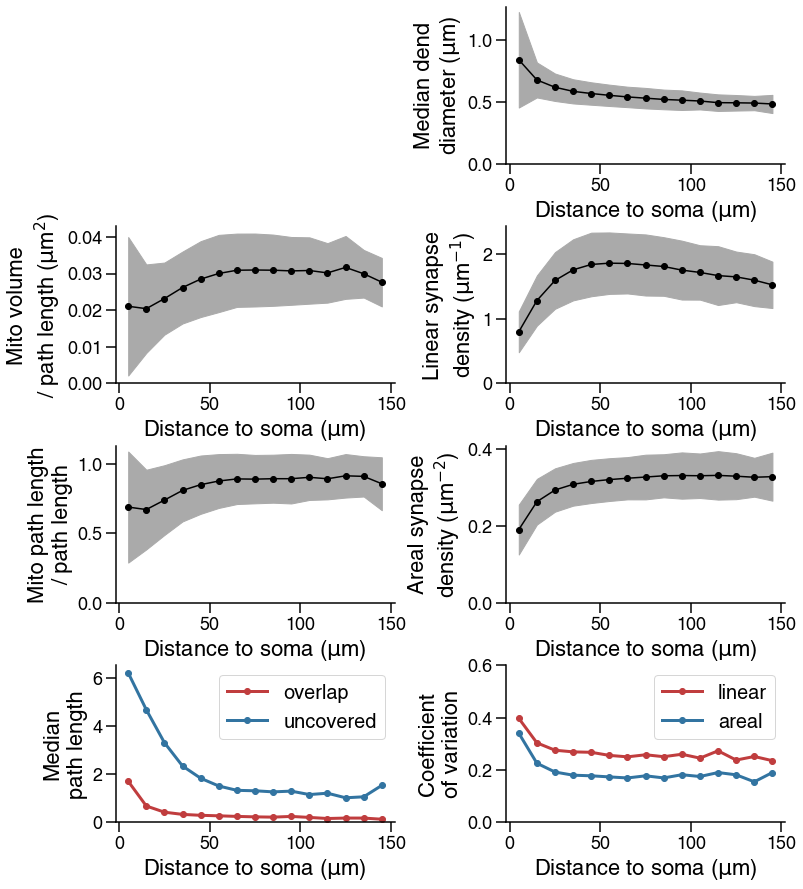

In [20]:
plt.figure(figsize=(12, 15))
fontsize = plot.AXIS_FONTSIZE - 3
axis_fontsize = 18

## Distance to soma gradient plots
# Diameter
plt.subplot(4, 2, 2)
plotgradient(dbifulldenddf, "mindisttosoma", "mediandiam")
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Median dend\ndiameter ($\mathrm{\mu}$m)", fontsize=fontsize)
plt.xticks(fontsize=axis_fontsize)
plt.yticks(fontsize=axis_fontsize)

# Average mito cross-section
plt.subplot(4, 2, 3)
plotgradient(dbifulldenddf, "mindisttosoma", "samcs")
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Mito volume\n/ path length (" + plot.MU +"m$^2$)", fontsize=fontsize)
plt.yticks([0, 0.01, 0.02, 0.03, 0.04])
plt.xticks(fontsize=axis_fontsize)
plt.yticks(fontsize=axis_fontsize)

# Linear synapse density
plt.subplot(4, 2, 4)
plotgradient(dbifulldenddf, "mindisttosoma", "linearsynapsedensity")
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Linear synapse\ndensity (" + plot.MU + "m$^{-1}$)", fontsize=fontsize)
plt.xticks(fontsize=axis_fontsize)
plt.yticks(fontsize=axis_fontsize)

# Mito index
plt.subplot(4, 2, 5)
plotgradient(dbifulldenddf, "mindisttosoma", "linearmitocoverage")
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Mito path length\n/ path length", fontsize=fontsize)
plt.xticks(fontsize=axis_fontsize)
plt.yticks(fontsize=axis_fontsize)

# Areal synapse density
plt.subplot(4, 2, 6)
plotgradient(dbifulldenddf, "mindisttosoma", "surfsynapsedensity")
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Areal synapse\ndensity (" + plot.MU + "m$^{-2}$)", fontsize=fontsize)
plt.xticks(fontsize=axis_fontsize)
plt.yticks(fontsize=axis_fontsize)

# Covered vs. overlap
plt.subplot(4, 2, 7)
plotgradient(dbifulldenddf, "mindisttosoma", "extracoveragelength", ylbl="",
             color=plot.COLORS[3], statstype="median", plottype="basic",
             label="overlap", lw=3, yto0=False)
plotgradient(dbifulldenddf, "mindisttosoma", "uncoveredpathlength", ylbl="",
             color=plot.COLORS[0], statstype="median", plottype="basic",
             label="uncovered", lw=3)
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Median\npath length", fontsize=fontsize)
plt.legend(prop={"family":"Helvetica", "size":20})
plt.xticks(fontsize=axis_fontsize)
plt.yticks(fontsize=axis_fontsize)

# Coefficient of variation
plt.subplot(4, 2, 8)
plotgradient(dbifulldenddf, "mindisttosoma", "linearsynapsedensity",
             statstype="COV", plottype="basic", label="linear",
             yto0=False, color=plot.COLORS[3], lw=3)
plotgradient(dbifulldenddf, "mindisttosoma", "surfsynapsedensity",
             statstype="COV", plottype="basic", label="areal",
             yto0=False, color=plot.COLORS[0], lw=3)
plot.yto0()
plt.legend(prop={"family":"Helvetica", "size":20})
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Coefficient\nof variation", fontsize=fontsize)
plt.ylim(0, 0.6)
plt.xticks(fontsize=axis_fontsize)
plt.yticks(fontsize=axis_fontsize)

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

## Supplemental figure

### Size gradients

/usr/people/nturner/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/people/nturner/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/people/nturner/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/people/nturner/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/people/nturner/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/people/nturner/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/people/nturner/miniconda3/lib/python3.7/site-pa

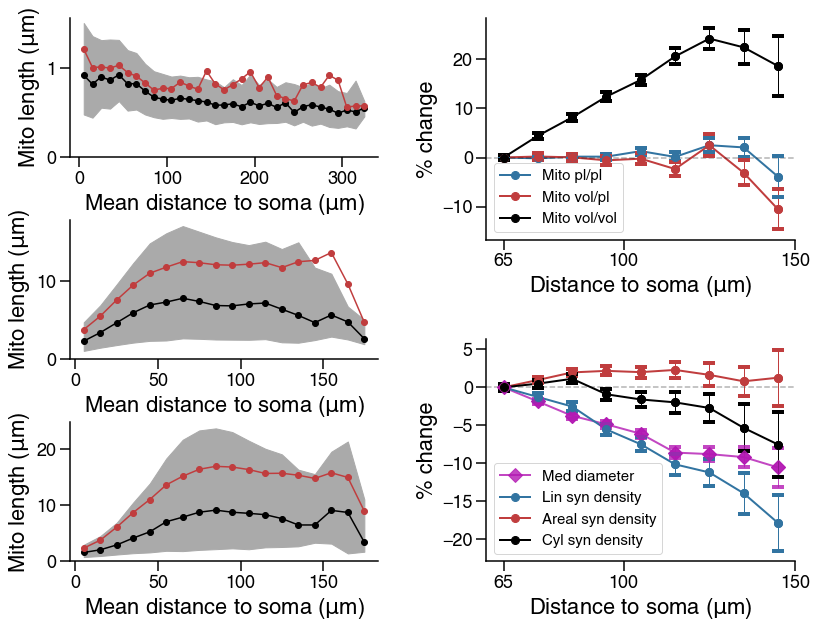

In [21]:
plt.figure(figsize=(13, 10))

fontsize = plot.AXIS_FONTSIZE - 3

def pg(*args, **kwargs):
    return plotgradient(*args, **kwargs)

tempdf = mitotoskeldf[np.isfinite(mitotoskeldf.nodedist) &
                      (mitotoskeldf.pathlength > 0) &
                      (mitotoskeldf.cellid.isin(analysisids))]


plt.subplot(3, 2, 1)
pg(tempdf[tempdf.nodelbl == 1], "nodedist", "pathlength",
   collapsecol="mitoid",
   statstype="IQR", increment=10, tick_spacing=100, yto0=False)
pg(tempdf[tempdf.nodelbl == 1], "nodedist", "pathlength",
   collapsecol="mitoid",
   statstype="mean", plottype="basic",
   tick_spacing=100, color=plot.COLORS[3])
plt.xlabel("Mean distance to soma ($\mathrm{\mu}$m)", fontsize=fontsize)
plt.ylabel("Mito length (" + plot.MU + "m)", fontsize=fontsize)


plt.subplot(3, 2, 3)
pg(tempdf[tempdf.nodelbl == 2], "nodedist", "pathlength",
   collapsecol="mitoid",
   statstype="IQR", increment=10, tick_spacing=100, yto0=False)
pg(tempdf[tempdf.nodelbl == 2], "nodedist", "pathlength",
   collapsecol="mitoid",
   statstype="mean", plottype="basic", color=plot.COLORS[3])
plt.xlabel("Mean distance to soma ($\mathrm{\mu}$m)", fontsize=fontsize)
plt.ylabel("Mito length (" + plot.MU + "m)", fontsize=fontsize)


plt.subplot(3, 2, 5)
pg(tempdf[tempdf.nodelbl == 3], "nodedist", "pathlength",
   collapsecol="mitoid",
   statstype="IQR", increment=10, tick_spacing=100, yto0=False)
pg(tempdf[tempdf.nodelbl == 3], "nodedist", "pathlength",
   collapsecol="mitoid",
   statstype="mean", plottype="basic", color=plot.COLORS[3])
plt.ylabel("Mito length (" + plot.MU + "m)", fontsize=fontsize)
plt.xlabel("Mean distance to soma ($\mathrm{\mu}$m)", fontsize=fontsize)


# % change (right half)
def pg_(varname, s, c, lbl):
    markersize = 8
    alpha = 1
    if s == 'D':
        markersize += 2
        alpha=0.8
    plotgradient(dbifulldenddf, "mindisttosoma", varname,
                 plottype="errorbar", statstype="meanstderr",
                 baseline=65, yto0=False,
                 capsize=6, capthick=4, alpha=alpha,
                 color=c, marker=s, markersize=markersize,
                 label="")
    plotgradient(dbifulldenddf, "mindisttosoma", varname,
                 plottype="basic", statstype="meanstderr",
                 baseline=65, yto0=False, alpha=alpha,
                 color=c, marker=s, markersize=markersize,
                 lw=2, label=lbl)

plt.subplot(2, 2, 2)
mitomeasurements = ["linearmitocoverage", "samcs", "mitovoldensity"]
labels = ["Mito pl/pl", "Mito vol/pl", "Mito vol/vol"]
mitosymbols = ['o', 'o', 'o']
mitocolors = [plot.COLORS[0], plot.COLORS[3], 'k']

for (m, s, c, lbl) in zip(mitomeasurements, mitosymbols, mitocolors, labels):
    pg_(m, s, c, lbl)
plt.axhline(0, ls='--', alpha=0.3, color='k')
plt.xticks([65, 100, 150])
plt.xlim(60, 150)
plt.legend(loc="lower left", prop={"family":"Helvetica", "size":15})
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("% change", fontsize=fontsize)

plt.subplot(2, 2, 4)
synmeasurements = ["mediandiam", "linearsynapsedensity",
                   "surfsynapsedensity", "cylindersynapsedensity"]
labels = ["Med diameter", "Lin syn density",
          "Areal syn density", "Cyl syn density"]
synsymbols = ['D', 'o', 'o', 'o', 'o']
syncolors = ["#cc00cc", plot.COLORS[0], plot.COLORS[3], 'k']

for (m, s, c, lbl) in zip(synmeasurements, synsymbols, syncolors, labels):
    pg_(m, s, c, lbl)
plt.axhline(0, ls='--', alpha=0.3, color='k')
plt.xlim(60, 150)
plt.xticks([65, 100, 150])
plt.legend(loc="lower left", prop={"family":"Helvetica", "size":15})
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("% change", fontsize=fontsize)

plt.subplots_adjust(hspace=0.45, wspace=0.35)
plt.show()

# cells: 343
# cells: 343
# cells: 343
# cells: 343
# cells: 343
# cells: 343
# cells: 343


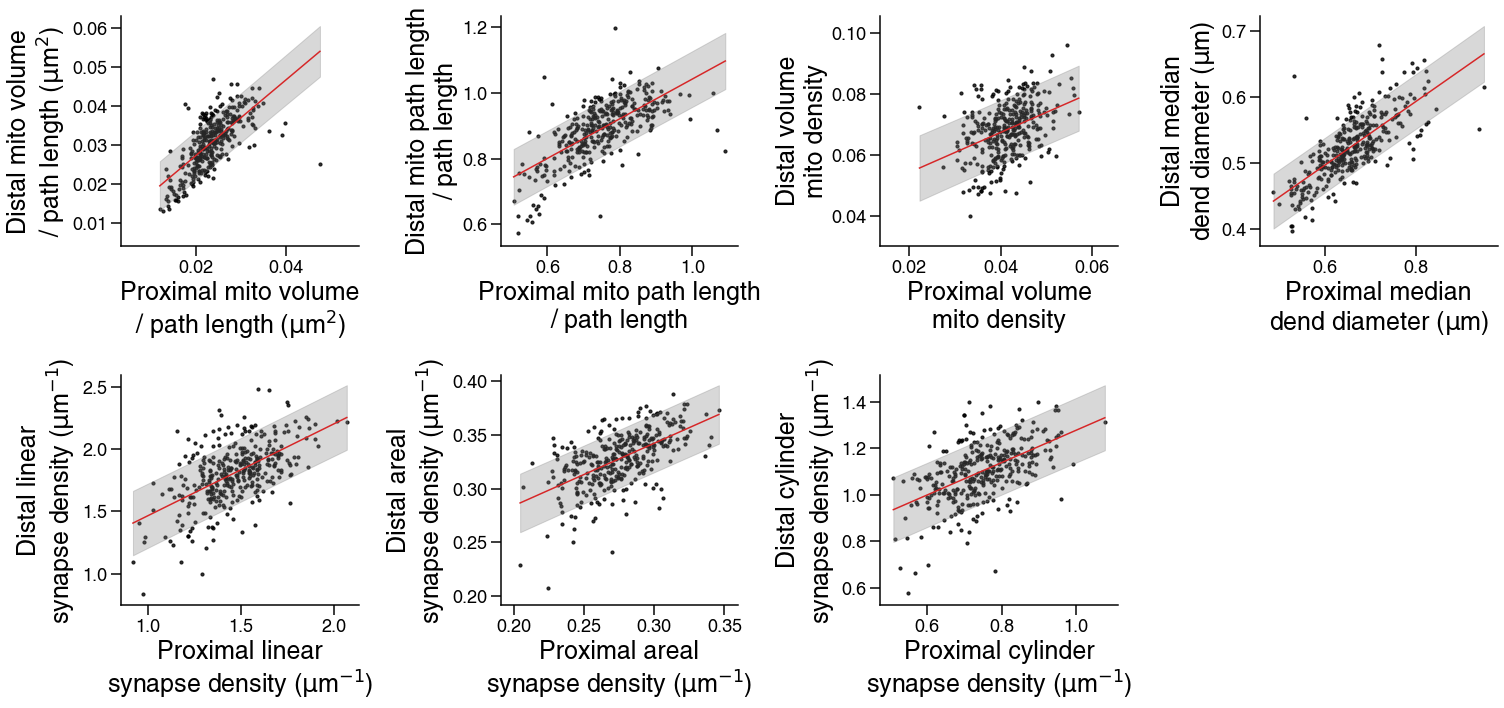

In [22]:
plt.figure(figsize=(21, 10))

fontsize = plot.AXIS_FONTSIZE

def plotcellpts(varname, axislbl=None):
    plot.plot_cellpts_df(dbifulldenddf, "mindisttosoma",
                         varname, axislbl=axislbl, fontsize=fontsize)
    
plt.subplot(2, 4, 1)
plotcellpts("samcs", "mito volume\n/ path length (" + plot.MU +"m$^2$)")

plt.subplot(2, 4, 2)
plotcellpts("linearmitocoverage", "Mito path length\n/ path length")

plt.subplot(2, 4, 3)
plotcellpts("mitovoldensity", "Volume\nmito density")

plt.subplot(2, 4, 4)
plotcellpts("mediandiam", "Median\ndend diameter ($\mathrm{\mu}$m)")

plt.subplot(2, 4, 5)
plotcellpts("linearsynapsedensity", "Linear\nsynapse density (" + plot.MU + "m$^{-1}$)")

plt.subplot(2, 4, 6)
plotcellpts("surfsynapsedensity", "Areal\nsynapse density (" + plot.MU + "m$^{-1}$)")

plt.subplot(2, 4, 7)
plotcellpts("cylindersynapsedensity", "Cylinder\nsynapse density (" + plot.MU + "m$^{-1}$)")

plt.subplots_adjust(hspace=0.45, wspace=0.35)
plt.tight_layout()
plt.show()

## Scatter plots

In [23]:
lm, regdf = modelling.residualregression(
                 dbidenddf, ["mediandiam"], ["samcs"],
                 "linearsynapsedensity")

In [24]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  resid   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     311.8
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           1.19e-68
Time:                        11:38:33   Log-Likelihood:                -5014.4
No. Observations:                9198   AIC:                         1.003e+04
Df Residuals:                    9196   BIC:                         1.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2445      0.015    -16.845      0.000      -0.273      -0.216
samcs          7.9135      0.448     17.658      0.000       7.035       8.792
==============================================================================
Omnibus:                       13.621   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.045
Skew:                          -0.013   Prob(JB):                     0.000328
Kurtosis:                       3.203   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Mito diameter vs. linear synapse density

const     1.260432
samcs    17.787093
dtype: float64
(0.37262824601481137, 6.8661579135641865e-301, 0.1388518097280748)
9198
const        -0.001463
mediandiam    0.061428
dtype: float64
(0.5140271172039961, 0.0, 0.26422387722105073)
9198
const         0.600897
mediandiam    2.295467
dtype: float64
(0.4024013518159681, 0.0, 0.16192684794331852)
9198
const   -0.244452
samcs    7.913513
dtype: float64
(0.1810919448637811, 1.1926783413261289e-68, 0.03279429249454674)
9198


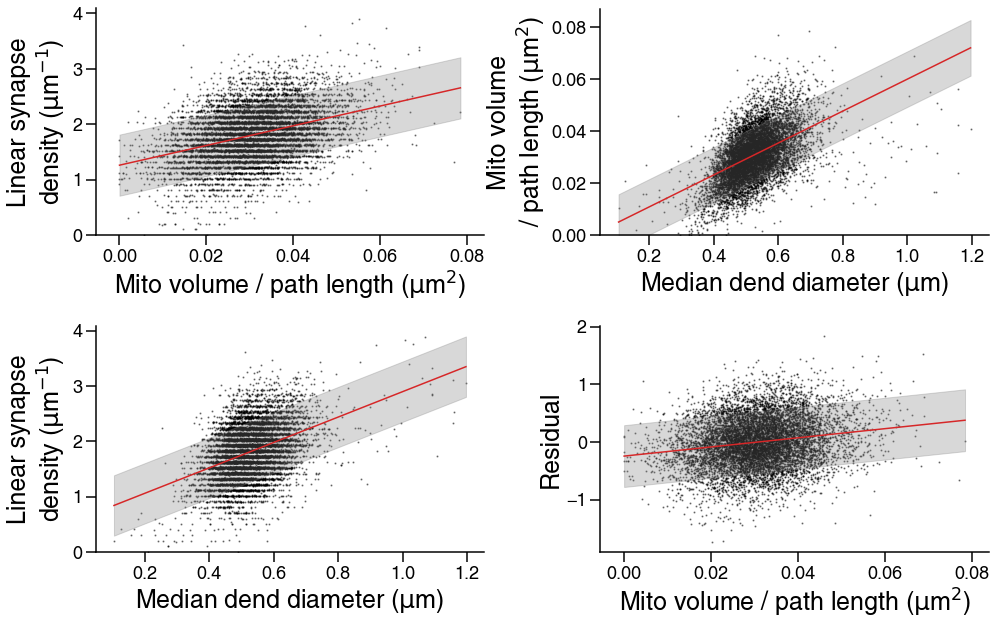

In [25]:
plt.figure(figsize=(16, 10))
alpha = 0.4
marker = '.'
size = 5
distance = 90
tempdf = regdf[(regdf.mindisttosoma < distance+5) &
               (regdf.mindisttosoma > distance-5)] # restricting to a particular distance
tempdf = regdf

plt.subplot(2, 2, 1)
scatterplotdf(tempdf, "samcs", "linearsynapsedensity",
              alpha=alpha, marker=marker, size=size, rasterized=True)
plt.xlabel("Mito volume / path length (" + plot.MU +"m$^2$)")
plt.ylabel("Linear synapse\ndensity (" + plot.MU + "m$^{-1}$)")
plot.yto0()

plt.subplot(2, 2, 2)
scatterplotdf(tempdf, "mediandiam", "samcs",
              alpha=alpha, marker=marker, size=size, rasterized=True)
plt.ylabel("Mito volume\n/ path length (" + plot.MU +"m$^2$)")
plot.yto0()

plt.subplot(2, 2, 3)
scatterplotdf(tempdf, "mediandiam", "linearsynapsedensity",
              alpha=alpha, marker=marker, size=size, rasterized=True)
plt.ylabel("Linear synapse\ndensity (" + plot.MU + "m$^{-1}$)")
plot.yto0()

plt.subplot(2, 2, 4)
scatterplotdf(tempdf, "samcs", "resid", ylbl="Residual",
              alpha=alpha, marker=marker, size=size, rasterized=True)
plt.xlabel("Mito volume / path length (" + plot.MU +"m$^2$)")

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

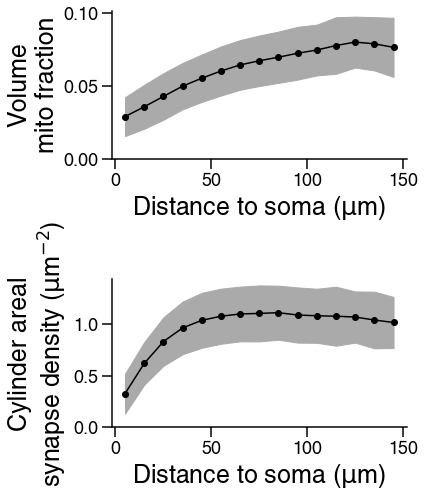

In [26]:
plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
plotgradient(dbifulldenddf, "mindisttosoma", "mitovoldensity")
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Volume\nmito fraction", fontsize=fontsize)
plt.yticks([0, 0.05, 0.1])

plt.subplot(2, 1, 2)
plotgradient(dbifulldenddf, "mindisttosoma", "cylindersynapsedensity")
plt.xlabel("Distance to soma (" + plot.MU +"m)", fontsize=fontsize)
plt.ylabel("Cylinder areal\nsynapse density (" + plot.MU + "m$^{-2}$)",
           fontsize=fontsize)

plt.tight_layout()
plt.show()

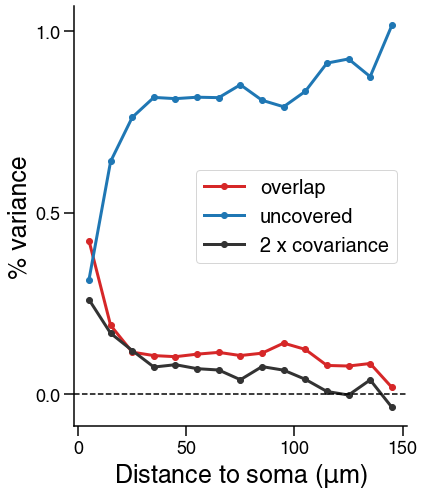

In [27]:
plt.figure(figsize=(6, 7))

plt.plot(cs, es, label="overlap", lw=3, color=plot.COLORS[3], marker='o')
plt.plot(cs, us, label="uncovered", lw=3, color=plot.COLORS[0], marker='o')
plt.plot(cs, covs, label="2 x covariance", lw=3, color="#333333", marker='o')
plt.axhline(0, color='k', ls='--')

plt.xlabel("Distance to soma ($\mathrm{\mu}$m)", fontsize=plot.AXIS_FONTSIZE)
plt.ylabel("% variance", fontsize=plot.AXIS_FONTSIZE)
plt.yticks([0, 0.5, 1])
plot.format_axes()
plt.legend(prop={"family":"Helvetica", "size":20})

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

## Dendritic segment count & cell count histogram

In [28]:
tempdf = dbifulldenddf.copy()
tempdf["group"] = tempdf["mindisttosoma"] // 10 * 10 + 5
countdf = tempdf.groupby("group")["branchid"].count()
cellcountdf = tempdf.groupby("group").agg({"cellid": "nunique"})

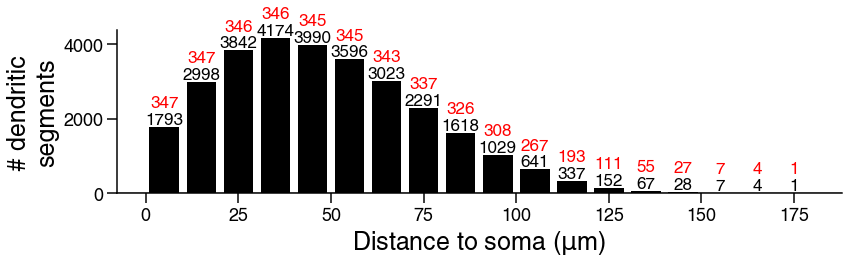

In [29]:
fig = plt.figure(figsize=(13, 3))

bars = plt.bar(np.arange(18) * 10 + 5, countdf, width=8, color='k')
for bar in bars:
    center = bar.get_x() + bar.get_width() / 2
    height = bar.get_height()
    ncells = cellcountdf.loc[center].item()
    plt.text(center, height,
             f'{height:d}', ha='center', va='bottom', fontsize=17,
             fontfamily="sans-serif", fontname="Helvetica")
    plt.text(center, height+450,
             f'{ncells:d}', ha='center', va='bottom', fontsize=17,
             fontfamily="sans-serif", fontname="Helvetica", color='r')
    
plot.yto0()
plt.axhline(0, color='k', alpha=0.3)
plt.xlabel("Distance to soma ($\mathrm{\mu}$m)", fontsize=plot.AXIS_FONTSIZE)
plt.ylabel("# dendritic\nsegments", fontsize=plot.AXIS_FONTSIZE)
plot.format_axes()

fig.patch.set_facecolor("white")
plt.show()